# Introduction

For this exercise, we will use historic weather data (source: meteo.gr, through [Kaggle](https://www.kaggle.com/datasets/spirospolitis/greek-weather-data)) to train two models to predict the weather for a specific time and place in Greece, one to predict the temperature through regression and one to predict level of rain as a classification problem.

While predicting the weather in general is a notoriously difficult problem and a lot of research has gone into constructing complex meteorological models using data from different sources, it will be interesting to see how well we can do by taking a naive machine learning approach.

In [ ]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, f1_score, classification_report
from matplotlib import pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn import preprocessing
%matplotlib inline

# Preprocessing

In [ ]:
! mkdir ~/.kaggle
! echo '{"username":"","key":""}' > ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download 'spirospolitis/greek-weather-data'
! unzip /content/greek-weather-data.zip
raw_data=pd.read_csv('/content/greek_weather_data.csv',delimiter='\t', dtype={'c':'int','d':'int','e':'int'}, index_col=0)

Dataset URL: https://www.kaggle.com/datasets/spirospolitis/greek-weather-data
License(s): unknown
 22% 5.00M/22.3M [00:00<00:00, 35.3MB/s]
100% 22.3M/22.3M [00:00<00:00, 95.3MB/s]
Archive:  /content/greek-weather-data.zip
  inflating: greek_weather_data.csv  


<ipython-input-2-166696fd4ebf>:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data=pd.read_csv('/content/greek_weather_data.csv',delimiter='\t', dtype={'c':'int','d':'int','e':'int'}, index_col=0)


There is a row with invalid data causing issues:

In [ ]:
print(raw_data[raw_data['DAY']=='DAY'])
raw_data=raw_data.drop(616680)
raw_data['DAY']=pd.to_numeric(raw_data['DAY'])

       STATION_REGION        STATION_NAME  YEAR  MONTH  DAY  MEAN_TEMP  \
616680   Πελοπόννησος  Λαγκάδια Γορτυνίας  2013      6  DAY        NaN   

        HIGH_TEMP HIGH_TEMP_TIME  LOW_TEMP LOW_TEMP_TIME  ...  RAIN  \
616680        NaN            NaN       NaN           NaN  ...   NaN   

        AVG_WIND_SPEED  HIGHEST_WIND_SPEED  HIGHEST_WIND_SPEED_TIME  WIND_DIR  \
616680             NaN                 NaN                      NaN       DIR   

       ELEVATION  LAT  LONG LAT_DEG LONG_DEG  
616680       NaN  NaN   NaN     NaN      NaN  

[1 rows x 22 columns]


Let's take a look at the dataset.

In [ ]:
raw_data

,STATION_REGION,STATION_NAME,YEAR,MONTH,DAY,MEAN_TEMP,HIGH_TEMP,HIGH_TEMP_TIME,LOW_TEMP,LOW_TEMP_TIME,...,RAIN,AVG_WIND_SPEED,HIGHEST_WIND_SPEED,HIGHEST_WIND_SPEED_TIME,WIND_DIR,ELEVATION,LAT,LONG,LAT_DEG,LONG_DEG
0,Ήπειρος,Αγία Κυριακή Ιωαννίνων,2018,10,1,14.6,21.7,15:10:00,10.4,23:50:00,...,0.0,1.3,24.1,15:40:00,SSE,515.0,"39° 31' 27"" N","20° 52' 55"" E",39.524167,20.881944
1,Ήπειρος,Αγία Κυριακή Ιωαννίνων,2018,10,2,14.3,21.6,17:40:00,6.2,07:30:00,...,0.4,2.1,22.5,14:40:00,ENE,515.0,"39° 31' 27"" N","20° 52' 55"" E",39.524167,20.881944
2,Ήπειρος,Αγία Κυριακή Ιωαννίνων,2018,10,3,14.6,22.7,13:40:00,8.4,06:40:00,...,3.6,1.8,24.1,18:20:00,ESE,515.0,"39° 31' 27"" N","20° 52' 55"" E",39.524167,20.881944
3,Ήπειρος,Αγία Κυριακή Ιωαννίνων,2018,10,4,17.6,26.7,15:50:00,11.2,05:40:00,...,0.2,1.6,17.7,13:30:00,WNW,515.0,"39° 31' 27"" N","20° 52' 55"" E",39.524167,20.881944
4,Ήπειρος,Αγία Κυριακή Ιωαννίνων,2018,10,5,16.7,26.3,14:10:00,10.8,06:20:00,...,1.8,2.7,20.9,10:40:00,WNW,515.0,"39° 31' 27"" N","20° 52' 55"" E",39.524167,20.881944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921556,Στερεά Ελλάδα,Ψυχικό,2018,12,27,5.5,8.7,13:20:00,2.2,01:10:00,...,0.0,1.4,25.7,11:50:00,NNE,209.0,"38° 00' 00"" N","23° 48' 00"" E",38.000000,23.800000
921557,Στερεά Ελλάδα,Ψυχικό,2018,12,28,7.0,10.7,14:30:00,5.3,23:00:00,...,0.0,0.3,8.0,13:50:00,W,209.0,"38° 00' 00"" N","23° 48' 00"" E",38.000000,23.800000
921558,Στερεά Ελλάδα,Ψυχικό,2018,12,29,9.2,14.1,13:10:00,4.5,03:50:00,...,0.0,2.3,24.1,15:30:00,NNE,209.0,"38° 00' 00"" N","23° 48' 00"" E",38.000000,23.800000
921559,Στερεά Ελλάδα,Ψυχικό,2018,12,30,8.9,10.7,12:10:00,7.5,18:20:00,...,0.0,1.1,19.3,00:20:00,NNE,209.0,"38° 00' 00"" N","23° 48' 00"" E",38.000000,23.800000


In [ ]:
raw_data.columns

Index(['STATION_REGION', 'STATION_NAME', 'YEAR', 'MONTH', 'DAY', 'MEAN_TEMP',
       'HIGH_TEMP', 'HIGH_TEMP_TIME', 'LOW_TEMP', 'LOW_TEMP_TIME',
       'HEAT_DEG_DAYS', 'COOL_DEG_DAYS', 'RAIN', 'AVG_WIND_SPEED',
       'HIGHEST_WIND_SPEED', 'HIGHEST_WIND_SPEED_TIME', 'WIND_DIR',
       'ELEVATION', 'LAT', 'LONG', 'LAT_DEG', 'LONG_DEG'],
      dtype='object')

It can be seen that our dataset has some superfluous columns (coordinates in two different formats, names of the stations in Greek) which we will remove prior to training. We will also have to reformat the dates into a more serviceable form and only keep the mean measurements for temperature and wind.

## Remove extreme outliers

As a first move in cleaning up the data, we will remove all measurements beyond [the most extreme temperatures](https://en.wikipedia.org/wiki/Climate_of_Greece#Temperature) officially recorded in Greece, assuming that they are the result of error.

In [ ]:
raw_data=raw_data[raw_data['LOW_TEMP']>-27.8]
raw_data=raw_data[raw_data['MEAN_TEMP']>-27.8]
raw_data=raw_data[raw_data['HIGH_TEMP']<48]
raw_data=raw_data[raw_data['MEAN_TEMP']<48]
raw_data.describe()

,YEAR,MONTH,DAY,MEAN_TEMP,HIGH_TEMP,LOW_TEMP,HEAT_DEG_DAYS,COOL_DEG_DAYS,RAIN,AVG_WIND_SPEED,HIGHEST_WIND_SPEED,ELEVATION,LAT_DEG,LONG_DEG
count,920258.000000,920258.000000,920258.000000,920258.000000,920258.000000,920258.000000,918572.000000,918541.000000,916703.000000,916940.000000,917006.000000,750147.000000,750147.000000,750147.000000
mean,2014.177501,6.666392,15.746403,16.192661,20.812402,12.072423,29.034346,17.629849,2.139197,6.545102,31.316166,306.089818,38.450687,23.035233
std,2.923225,3.449094,8.799304,7.596308,8.333013,7.371792,37.299476,24.810305,7.620049,6.184232,14.800370,410.177991,1.716666,2.045872
min,2006.000000,1.000000,1.000000,-18.800000,-15.900000,-27.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,27.947222,12.100000
25%,2012.000000,4.000000,8.000000,10.900000,14.900000,7.100000,0.900000,0.000000,0.000000,2.400000,20.900000,20.000000,37.666667,21.650000
50%,2015.000000,7.000000,16.000000,16.200000,20.700000,12.200000,7.000000,3.600000,0.000000,4.800000,29.000000,107.000000,38.400000,22.958889
75%,2017.000000,10.000000,23.000000,22.300000,27.500000,17.600000,75.000000,36.000000,0.200000,8.500000,38.600000,511.000000,39.618889,24.000000
max,2018.000000,12.000000,31.000000,41.400000,45.900000,38.600000,213.400000,100.000000,417.200000,90.600000,222.100000,2245.000000,43.000000,35.500000


## Fill missing coordinates

An issue obvious from the above table is the large number of nan values in coordinate and elevation measurements. Further investigation shows that a few weather stations are entirely missing location data:

In [ ]:
stations_with_nan=list(set(raw_data[raw_data['ELEVATION'].isnull()]['STATION_NAME']))
print(stations_with_nan)

['Ελατοχώρι Πιερίας (Χ/Κ)', 'Στύψη Λέσβου', 'Αμοργός', 'Ρόδος', 'Νέος Καύκασος', 'Ανάφη', 'Πέραμα', 'Ηράκλειο Ανατολικά', 'Σέρρες', 'Σέσι Παρνασσού', 'Καλάβρυτα', 'Δοξάτο Δράμας', 'Αρφαρά Μεσσηνίας', 'Κορυδαλλός', 'Θεσσαλονίκη (Καλαμαριά)', 'Καστελλόριζο', 'Μικρόκαμπος Δράμας', 'Απείρανθος Νάξου', 'Λαγκάδια Γορτυνίας', 'Σιμωνόπετρα', 'Χαϊδάρι (Δάσος)', 'Αργυρούπολη Δράμας', 'Σίνδος', 'Καβάλα', 'Στεμνίτσα Αρκαδίας', 'Κουφονήσια', 'Δαμαρίωνας Νάξου', 'Απόλλωνας Νάξου', 'Ελασσόνα Λάρισας', 'Κυπαρισσία Μεσσηνίας', 'Κερασιά Πέλλας', 'Νίκαια Αττικής', 'Ελευσίνα', 'ΣΚΑ', 'Διακόπι Φωκίδας', 'Βαμβακού Φαρσάλων', 'Σχοινούσα', 'Πύλος', 'Βαθύσταλος Παρνασσού', 'Βίλια Αττικής', 'Πάτρα', 'Πεζά Ηρακλείου', 'Πτολεμαΐδα Vb', 'Καρπενήσι - Πόλη', 'ΔΕΘ', 'Λεπιανά Άρτας', 'Καλαμπάκι Δράμας', 'Σταλός Χανίων', 'Κοπανάκι Μεσσηνίας', 'Πεντέλη', 'Μέλανες Νάξου', 'Μήλος', 'Μαλακάσα', 'Κονιάκος Φωκίδας', 'Κυριάκι Βοιωτίας', 'Πτολεμαΐδα Va', 'Τρίκαλα Κορινθίας', 'Φωτολίβος Δράμας', 'Ηράκλειο Λιμάνι', 'Φούρνοι', 'Σ

In [ ]:
raw_data[raw_data['STATION_NAME'].isin(stations_with_nan)].loc[:,['ELEVATION','LAT_DEG','LONG_DEG']].describe()

,ELEVATION,LAT_DEG,LONG_DEG
count,0.0,0.0,0.0
mean,NaN,NaN,NaN
std,NaN,NaN,NaN
min,NaN,NaN,NaN
25%,NaN,NaN,NaN
50%,NaN,NaN,NaN
75%,NaN,NaN,NaN
max,NaN,NaN,NaN


A viable solution, given the difficulty in manually collecting that data, is to fill the missing data with the average values for the region each station is in. Although it should be noted that the elevation has very large variance and as such taking the average value might be misleading:

In [ ]:
region_locations=raw_data.loc[:,['STATION_REGION','LAT_DEG','LONG_DEG','ELEVATION']].groupby(['STATION_REGION']).describe()
region_locations

LAT_DEG                                             \
                   count       mean       std        min        25%   
STATION_REGION                                                        
Ήπειρος          83970.0  39.574844  0.320185  38.982778  39.398333   
Θεσσαλία         36677.0  39.460743  0.160980  39.177778  39.375278   
Θράκη            20019.0  41.200586  0.256718  40.858333  40.955278   
Κρήτη            81560.0  35.239323  0.148659  35.000000  35.130000   
Μακεδονία       118813.0  40.629368  0.464243  39.700000  40.390556   
Ν. Αιγαίου       86254.0  37.950050  1.235537  35.416389  37.100000   
Ν. Ιονίου        17084.0  38.758022  0.628263  37.781389  38.400000   
Πελοπόννησος    116003.0  37.716368  0.437241  36.700000  37.483611   
Στερεά Ελλάδα   189767.0  38.132857  1.043945  27.947222  38.000000   

                                                 LONG_DEG             ...  \
                      50%        75%        max     count       mean  ...   
STATION_REGION                                                        ...   
Ήπειρος         39.531111  39.800000  40.600000   83970.0  20.854843  ...   
Θεσσαλία        39.450556  39.558056  39.779444   36677.0  22.357461  ...   
Θράκη           41.083333  41.420000  41.505833   20019.0  25.873963  ...   
Κρήτη           35.211111  35.366667  35.516944   81560.0  25.148214  ...   
Μακεδονία       40.541389  40.833333  43.000000  118813.0  22.394106  ...   
Ν. Αιγαίου      37.637500  39.150000  40.466667   86254.0  25.506593  ...   
Ν. Ιονίου       38.827222  39.206389  39.647222   17084.0  20.489278  ...   
Πελοπόννησος    37.727222  38.009722  38.390833  116003.0  22.041619  ...   
Στερεά Ελλάδα   38.200000  38.533333  38.936944  189767.0  23.038128  ...   

                                     ELEVATION                                \
                      75%        max     count        mean         std   min   
STATION_REGION                                                                 
Ήπειρος         21.096389  23.000000   83970.0  597.882887  388.919074   0.0   
Θεσσαλία        22.983333  23.246111   36677.0  420.605011  384.252346   0.0   
Θράκη           26.500000  26.534722   20019.0   51.670063   50.182256  10.0   
Κρήτη           25.156111  35.500000   81560.0  219.191135  260.937612   3.0   
Μακεδονία       23.100000  24.211667  118813.0  447.989799  522.356096   0.0   
Ν. Αιγαίου      26.300000  28.086389   86254.0   80.962112  133.448056   0.0   
Ν. Ιονίου       20.710556  21.300000   17084.0   21.213182   27.268084   5.0   
Πελοπόννησος    22.440000  23.250000  116003.0  197.315897  292.153675   0.0   
Στερεά Ελλάδα   23.837500  24.583056  189767.0  324.650919  456.179731   0.0   

                                            
                 25%    50%    75%     max  
STATION_REGION                              
Ήπειρος         77.0  675.0  940.0  1240.0  
Θεσσαλία        82.0  238.0  796.0  1170.0  
Θράκη           20.0   40.0   47.0   162.0  
Κρήτη           30.0   85.0  405.0  1250.0  
Μακεδονία       30.0  290.0  650.0  2090.0  
Ν. Αιγαίου      10.0   20.0   65.0   515.0  
Ν. Ιονίου        7.0   10.0   12.0    80.0  
Πελοπόννησος    11.0   59.0  231.0  1207.0  
Στερεά Ελλάδα   55.0  144.0  376.0  2245.0  

[9 rows x 24 columns]

In [ ]:
for station in stations_with_nan:
    region=raw_data.loc[raw_data['STATION_NAME'] == station].iloc[0]['STATION_REGION']
    raw_data.loc[raw_data['STATION_NAME'] == station, 'LAT_DEG'] = region_locations['LAT_DEG']['mean'][region]
    raw_data.loc[raw_data['STATION_NAME'] == station, 'LONG_DEG'] = region_locations['LONG_DEG']['mean'][region]
    raw_data.loc[raw_data['STATION_NAME'] == station, 'ELEVATION'] = region_locations['ELEVATION']['mean'][region]

Next we will drop most columns and only keep the features we will use for the prediction. Those are year, time of year, average speed and direction of wind, elevation, latitude and longitude, average temperature, and rain.

In [ ]:
data=raw_data[['YEAR','MONTH','DAY','AVG_WIND_SPEED','WIND_DIR','ELEVATION','LAT_DEG','LONG_DEG','MEAN_TEMP', 'RAIN']]
data.describe()

,YEAR,MONTH,DAY,AVG_WIND_SPEED,ELEVATION,LAT_DEG,LONG_DEG,MEAN_TEMP,RAIN
count,920258.000000,920258.000000,920258.000000,916940.000000,920258.000000,920258.000000,920258.000000,920258.000000,916703.000000
mean,2014.177501,6.666392,15.746403,6.545102,297.730860,38.414717,23.109898,16.192661,2.139197
std,2.923225,3.449094,8.799304,6.184232,375.117577,1.682030,1.951579,7.596308,7.620049
min,2006.000000,1.000000,1.000000,0.000000,0.000000,27.947222,12.100000,-18.800000,0.000000
25%,2012.000000,4.000000,8.000000,2.400000,34.000000,37.716368,21.800000,10.900000,0.000000
50%,2015.000000,7.000000,16.000000,4.800000,156.000000,38.200000,22.961944,16.200000,0.000000
75%,2017.000000,10.000000,23.000000,8.500000,447.989799,39.558056,24.100000,22.300000,0.200000
max,2018.000000,12.000000,31.000000,90.600000,2245.000000,43.000000,35.500000,41.400000,417.200000


## Clean up and reformat WIND_DIR

Let's take a look at the categorical feature not appearing above, wind direction.

In [ ]:
data['WIND_DIR'].value_counts()

,count
WIND_DIR,
N,82305
NE,70757
NW,70167
W,64689
NNE,59884
SW,59096
WNW,58857
ENE,57187
E,52997


In [ ]:
data[data['WIND_DIR']=='---'].describe()

,YEAR,MONTH,DAY,AVG_WIND_SPEED,ELEVATION,LAT_DEG,LONG_DEG,MEAN_TEMP,RAIN
count,10789.00000,10789.000000,10789.000000,7635.000000,10789.000000,10789.000000,10789.000000,10789.000000,10512.000000
mean,2012.93688,6.474557,15.816572,5.699175,547.974630,38.612058,23.024400,12.928260,1.856954
std,2.99304,3.696824,8.694374,8.844953,685.442437,1.564063,1.622288,9.320398,6.868319
min,2006.00000,1.000000,1.000000,0.000000,0.000000,35.000000,12.100000,-15.900000,0.000000
25%,2011.00000,3.000000,8.000000,0.000000,39.000000,37.800000,21.925278,7.200000,0.000000
50%,2013.00000,6.000000,16.000000,2.100000,280.000000,38.400000,22.600000,13.600000,0.000000
75%,2015.00000,10.000000,23.000000,8.000000,785.000000,40.058333,24.010833,19.800000,0.400000
max,2018.00000,12.000000,31.000000,90.600000,2245.000000,43.000000,35.500000,39.400000,233.200000


<Axes: xlabel='AVG_WIND_SPEED', ylabel='WIND_DIR'>

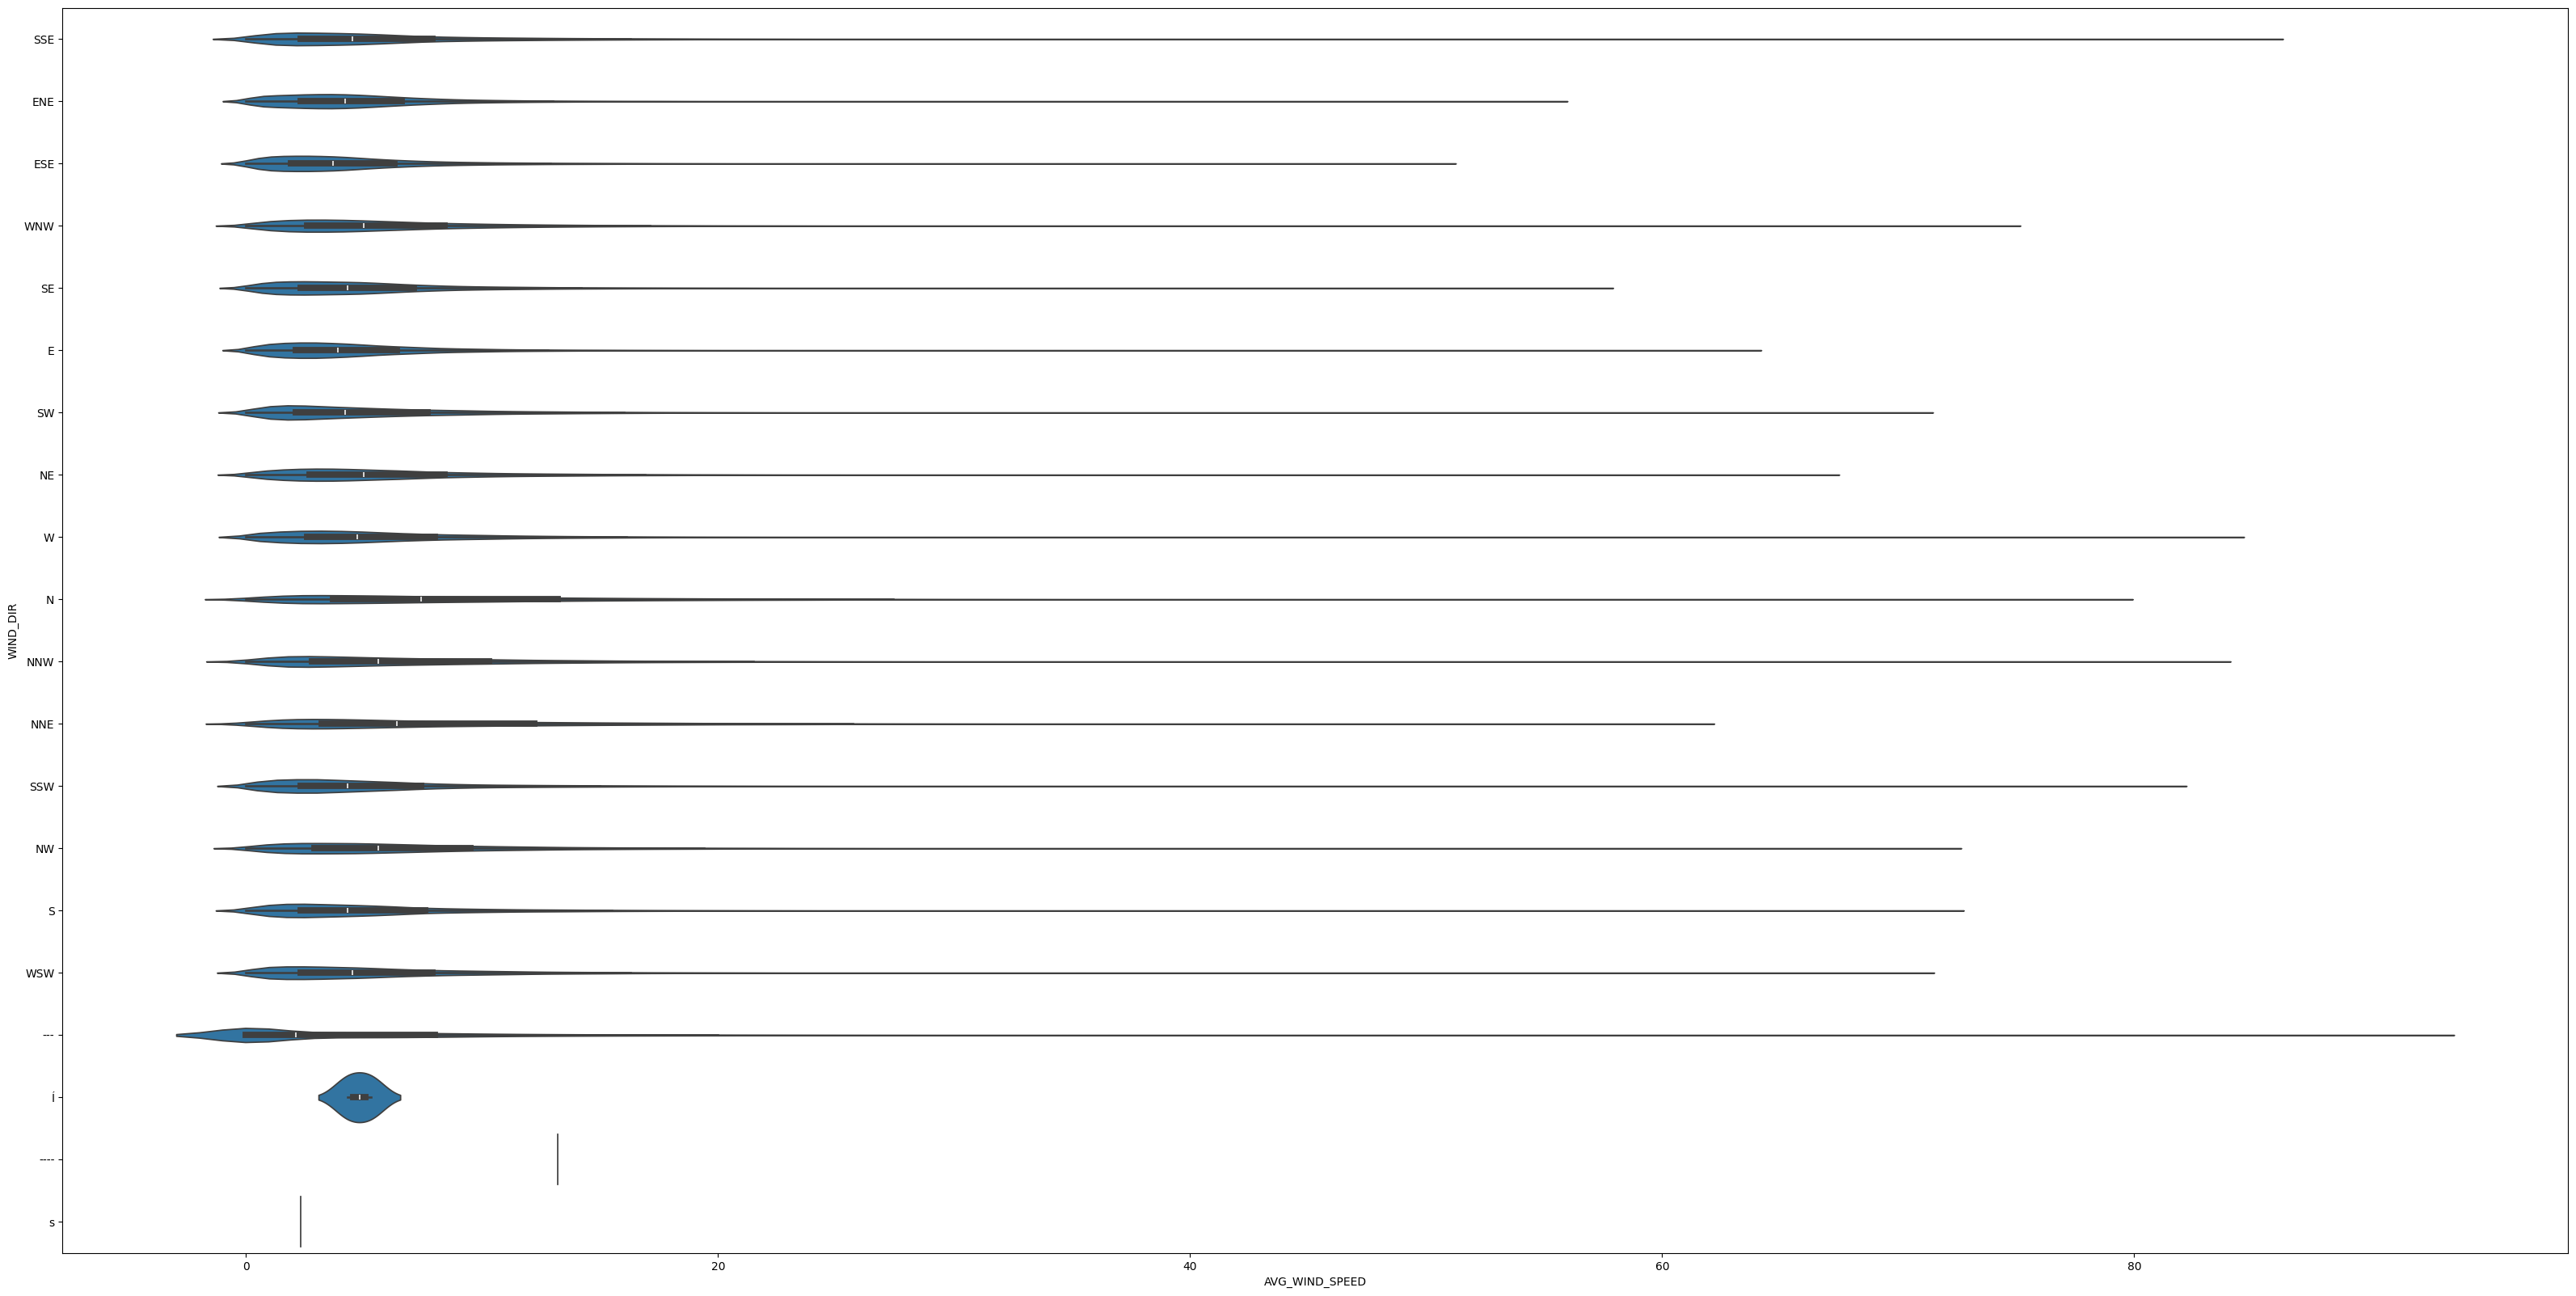

In [ ]:
plt.figure(figsize=(40,20))
sns.violinplot(data=data, y='WIND_DIR', x='AVG_WIND_SPEED')

The value '---' is presumably meant to indicate a lack of wind, but as it is often accompanied by an average wind speed value greater than 0, how it should be handled is less clear. Still, the small number of samples means it might be safer to remove them, along with the invalid wind directions.

In [ ]:
data=data[~ data['WIND_DIR'].isin(['---','----','s','Í'])]
data.describe()

,YEAR,MONTH,DAY,AVG_WIND_SPEED,ELEVATION,LAT_DEG,LONG_DEG,MEAN_TEMP,RAIN
count,909465.000000,909465.000000,909465.000000,909301.000000,909465.000000,909465.000000,909465.000000,909465.000000,906187.000000
mean,2014.192225,6.668659,15.745543,6.552206,294.760269,38.412381,23.110901,16.231434,2.142479
std,2.919222,3.445981,8.800536,6.156548,368.859401,1.683238,1.955091,7.565023,7.628293
min,2006.000000,1.000000,1.000000,0.000000,0.000000,27.947222,12.100000,-18.800000,0.000000
25%,2012.000000,4.000000,8.000000,2.500000,34.000000,37.716368,21.800000,10.900000,0.000000
50%,2015.000000,7.000000,16.000000,4.800000,156.000000,38.200000,22.983333,16.200000,0.000000
75%,2017.000000,10.000000,23.000000,8.500000,447.989799,39.558056,24.100000,22.300000,0.200000
max,2018.000000,12.000000,31.000000,84.900000,2245.000000,43.000000,35.500000,41.400000,417.200000


Next we will reformat the wind direction into more convenient numeric values (which can be though to represent an angle from the start of the unit circle, since the feature is cyclical).

In [ ]:
cardinal_dirs=['E','ENE','NE','NNE','N','NNW','NW','WNW','W','WSW','SW','SSW','S','SSE','SE','ESE']
data=data.replace(cardinal_dirs,[i for i in range(len(cardinal_dirs))])

## Reformat dates

Since we know that the weather follows a year-long cycle, we will process the month and day columns into a single 'day of year' feature.

In [ ]:
data['DAY']=data['DAY'].astype(int)
data['MONTH']=data['MONTH'].astype(int)
data['YEAR']=data['YEAR'].astype(int)
def day_of_year(row):
    try:
        return dt.datetime(int(row['YEAR']), int(row['MONTH']), int(row['DAY'])).timetuple().tm_yday
    except ValueError:
        return None


data['DAY_OF_YEAR']=data.apply(day_of_year , axis=1)

In [ ]:
data[data['DAY_OF_YEAR'].isnull()][['YEAR','MONTH','DAY','DAY_OF_YEAR']]

,YEAR,MONTH,DAY,DAY_OF_YEAR
103974,2011,11,31,NaN
198851,2018,6,31,NaN
263195,2011,4,31,NaN
475618,2009,2,29,NaN
475619,2009,2,30,NaN
475620,2009,2,31,NaN
571720,2018,6,31,NaN
571874,2018,11,31,NaN
573748,2018,6,31,NaN
616685,2013,6,31,NaN


Some invalid dates (31st of November, etc) have to be removed. At this point we will also remove all NaN values, since they are a very small fraction of the remaining samples.

In [ ]:
print(data.isnull().sum())
data=data.dropna()

YEAR                 0
MONTH                0
DAY                  0
AVG_WIND_SPEED     164
WIND_DIR             0
ELEVATION            0
LAT_DEG              0
LONG_DEG             0
MEAN_TEMP            0
RAIN              3278
DAY_OF_YEAR         12
dtype: int64


The redundant month and day columns can now be dropped.

In [ ]:
data=data[['YEAR','DAY_OF_YEAR','LAT_DEG','LONG_DEG','ELEVATION','WIND_DIR','AVG_WIND_SPEED','MEAN_TEMP','RAIN']]

## Use visualisations to find and fix bad values

Let's take a look at the temperatures by day of year:

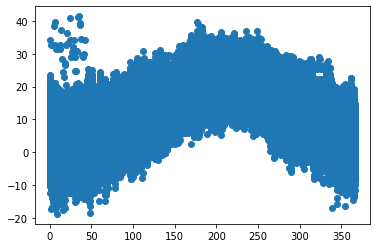

In [ ]:
plt.scatter(data['DAY_OF_YEAR'],data['MEAN_TEMP'])

It seems that there are a few suspicious measurements that are likely to be errors.

In [ ]:
data.loc[data['DAY_OF_YEAR']<70].loc[data['MEAN_TEMP']>23]

,YEAR,DAY_OF_YEAR,LAT_DEG,LONG_DEG,ELEVATION,WIND_DIR,AVG_WIND_SPEED,MEAN_TEMP,RAIN
5720,2012,1.0,39.831111,20.720556,945.000000,1,5.9,34.1,0.00
5721,2012,2.0,39.831111,20.720556,945.000000,10,2.1,32.7,0.00
5724,2012,5.0,39.831111,20.720556,945.000000,12,3.7,38.3,0.20
5725,2012,6.0,39.831111,20.720556,945.000000,13,7.7,39.5,2.36
5726,2012,7.0,39.831111,20.720556,945.000000,5,9.8,32.5,0.02
5727,2012,8.0,39.831111,20.720556,945.000000,1,5.5,31.4,0.00
5728,2012,9.0,39.831111,20.720556,945.000000,1,3.4,31.4,0.00
5729,2012,10.0,39.831111,20.720556,945.000000,14,5.6,32.3,0.00
5730,2012,11.0,39.831111,20.720556,945.000000,14,6.7,32.3,0.00
5731,2012,12.0,39.831111,20.720556,945.000000,1,3.8,32.6,0.00


In [ ]:
data=data.drop(range(5720,5762),errors='ignore')

The rest of the outliers seem to be legitimate measurements. We will do the same for the rain:

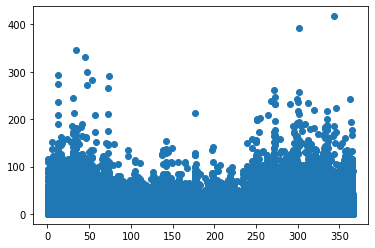

In [ ]:
plt.scatter(data['DAY_OF_YEAR'],data['RAIN'])

In [ ]:
data[data['RAIN']>300]

,YEAR,DAY_OF_YEAR,LAT_DEG,LONG_DEG,ELEVATION,WIND_DIR,AVG_WIND_SPEED,MEAN_TEMP,RAIN
32577,2018,34.0,39.435833,21.209722,974.0,12,9.5,7.4,346.8
94135,2012,302.0,39.500000,21.300000,0.0,8,4.7,15.3,392.8
111863,2009,344.0,39.400000,22.983333,796.0,3,40.7,5.5,417.2
239001,2018,45.0,35.283333,24.566667,210.0,12,20.9,12.4,331.6


In [ ]:
pd.concat([data.loc[32575:32579],data.loc[94133:94137],data.loc[111861:111865],data.loc[238999:239003]])

,YEAR,DAY_OF_YEAR,LAT_DEG,LONG_DEG,ELEVATION,WIND_DIR,AVG_WIND_SPEED,MEAN_TEMP,RAIN
32575,2018,32.0,39.435833,21.209722,974.0,15,3.4,4.4,0.0
32576,2018,33.0,39.435833,21.209722,974.0,11,11.7,7.2,38.4
32577,2018,34.0,39.435833,21.209722,974.0,12,9.5,7.4,346.8
32578,2018,35.0,39.435833,21.209722,974.0,8,6.0,6.1,96.2
32579,2018,36.0,39.435833,21.209722,974.0,9,2.1,3.7,0.0
94133,2012,300.0,39.500000,21.300000,0.0,8,1.1,10.3,0.0
94134,2012,301.0,39.500000,21.300000,0.0,8,7.9,11.4,107.6
94135,2012,302.0,39.500000,21.300000,0.0,8,4.7,15.3,392.8
111861,2009,342.0,39.400000,22.983333,796.0,14,5.8,7.3,0.0
111862,2009,343.0,39.400000,22.983333,796.0,15,4.3,8.4,5.4


It's much harder to say whether these outliers are errors or actual extreme weather events. In the absence of evidence we will keep them as samples.

Finally, let's check for errors in the coordinates. This data lends itself to a delightfully obvious visualisation:

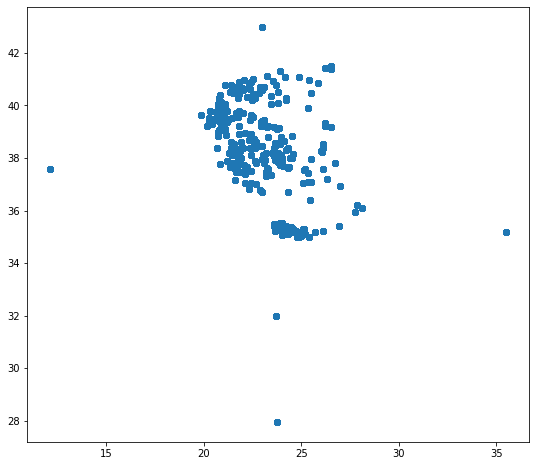

In [ ]:
plt.figure(figsize=(9,8))
plt.scatter(data['LONG_DEG'],data['LAT_DEG'])

In [ ]:
bad_coords_filter=(raw_data['LAT_DEG']<34) | (raw_data['LAT_DEG']>42) | (raw_data['LONG_DEG']<15) | (raw_data['LONG_DEG']>30)
raw_data[bad_coords_filter].loc[:,['STATION_NAME','LAT_DEG','LONG_DEG']].drop_duplicates()

,STATION_NAME,LAT_DEG,LONG_DEG
223396,Τζερμιάδων,35.200000,35.500000
336172,Κοίμηση Σερρών,43.000000,23.000000
729303,Αράχωβα,37.600000,12.100000
862651,Πατήσια,32.000000,23.700000
905734,Υμηττός - Δάφνη,27.947222,23.748056


An online search for those station names reveals that either the latitude or the longitude of each is off by one digit from the actual coordinates, which are amended below:

In [ ]:
data['LAT_DEG']=data['LAT_DEG'].replace({43.0:41.0, 32.0:38.0, 27.947222:37.947222})
data['LONG_DEG']=data['LONG_DEG'].replace({12.1:22.1,35.5:25.5})

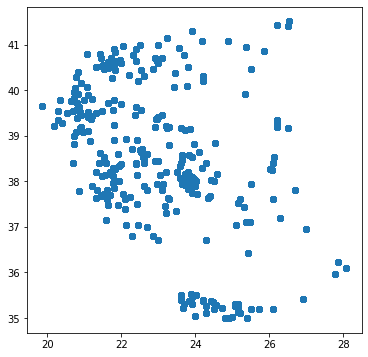

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(data['LONG_DEG'],data['LAT_DEG'])

This map looks a lot more recognisable!

For a last sanity check let's compare each feature to the ones we're trying to predict:

CPU times: user 1min 36s, sys: 4.18 s, total: 1min 40s
Wall time: 1min 39s


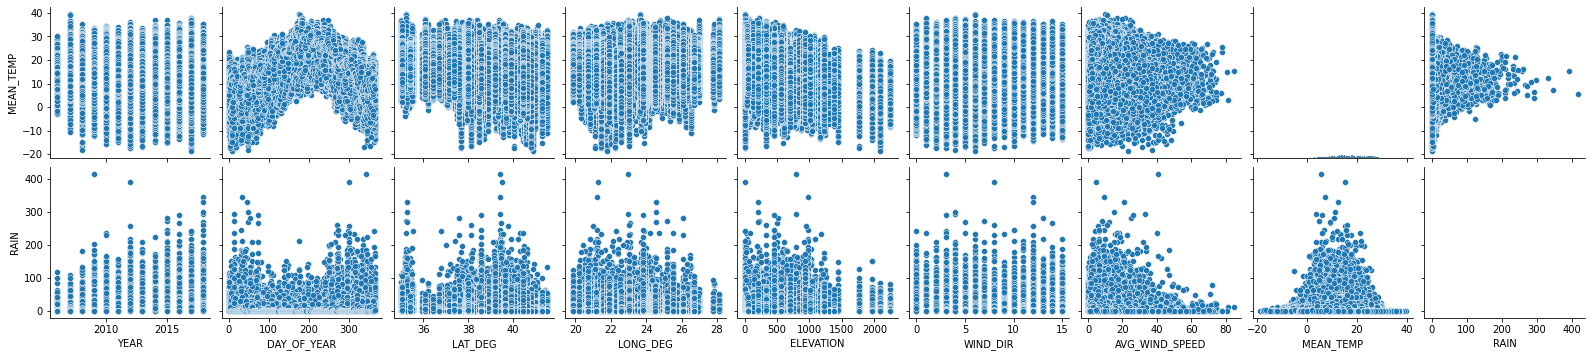

In [ ]:
%%time
sns.pairplot(data,y_vars=['MEAN_TEMP','RAIN'])

## Reformat rain

In [ ]:
pd.DataFrame({'across all days':data['RAIN'].describe(),'across rainy days':data[data['RAIN']>0]['RAIN'].describe()})

,across all days,across rainy days
count,905972.000000,273129.000000
mean,2.142117,7.105426
std,7.626851,12.557096
min,0.000000,0.200000
25%,0.000000,0.400000
50%,0.000000,2.400000
75%,0.200000,8.400000
max,417.200000,417.200000


Since the exact measurement of how many millimetres of rain will fall in one day is usually not as much of a concern as whether it we will rain at all (and also because we need a classification problem), we will split rainfall into two classes, 'rain' or 'no rain'.

In [ ]:
data['RAIN']=data['RAIN'].apply(lambda x: 0 if x==0 else 1)

# Regression

Time to train our regression models. Since this is a regression problem the metrics we use to compare them will be the mean squared error and R2.

In [ ]:
X = data.drop(['MEAN_TEMP','RAIN'],axis=1)
y = data['MEAN_TEMP']
X_train_raw, X_test_raw, y_train_raw, y_test=train_test_split(X,y,test_size=0.1,random_state=1010034)

## Linear Regression

We are going to standardize the input using scikit's StandardScaler (MinMaxScaler was also tried with almost no difference in results).

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = pd.DataFrame(scaler.transform(X_train_raw), index=X_train_raw.index, columns=X_train_raw.columns)
X_test = pd.DataFrame(scaler.transform(X_test_raw), index=X_test_raw.index, columns=X_test_raw.columns)

In [ ]:
linear_model=LinearRegression()
linear_model.fit(X_train,y_train_raw)

LinearRegression()

In [ ]:
y_pred = pd.DataFrame(linear_model.predict(X_test),index=X_test.index)
print('MSE =',sklearn.metrics.mean_squared_error(y_test,y_pred))
print('R2 =',sklearn.metrics.r2_score(y_test,y_pred))

MSE = 48.533432529719946
R2 = 0.14751949721826463


Not good at all! But that perhaps is to be expected considering one of the most important features, day of year, has a non-linear relationship to temperature. Let's try polynomial regression next.

## Polynomial Regression

In scikit-learn, polynomial regression is done by producing all combinations of features up to a specified degree, then passing them to linear regression. We will do this for different degrees and assess which produces the best result using our metrics. We will also use K-Fold cross validation to ensure there is no overfitting.

In [ ]:
%%time
degrees=[2,3,4]
mse=list()
r2=list()

k=5
for d in degrees:
    mse_sum=0
    r2_sum=0
    kf = KFold(n_splits=k)
    for train_index, val_index in kf.split(X_train_raw, y_train_raw):
        X_train, X_val = X_train_raw.iloc[train_index], X_train_raw.iloc[val_index]
        y_train, y_val = y_train_raw.iloc[train_index], y_train_raw.iloc[val_index]

        poly = PolynomialFeatures(degree=d)
        X_train_poly = pd.DataFrame(poly.fit_transform(X_train),index=X_train.index)
        X_val_poly = pd.DataFrame(poly.transform(X_val),index=X_val.index)

        scaler = StandardScaler()
        scaler.fit(X_train_poly)
        X_train = pd.DataFrame(scaler.transform(X_train_poly), index=X_train_poly.index)
        X_val = pd.DataFrame(scaler.transform(X_val_poly), index=X_val_poly.index)

        poly_model=LinearRegression()
        poly_model.fit(X_train,y_train)

        y_pred = pd.DataFrame(poly_model.predict(X_val),index=X_val.index)
        mse_sum+=mean_squared_error(y_val,y_pred)
        r2_sum+=r2_score(y_val,y_pred)
    mse.append(mse_sum/k)
    r2.append(r2_sum/k)

CPU times: user 6min 5s, sys: 25.8 s, total: 6min 31s
Wall time: 4min 5s


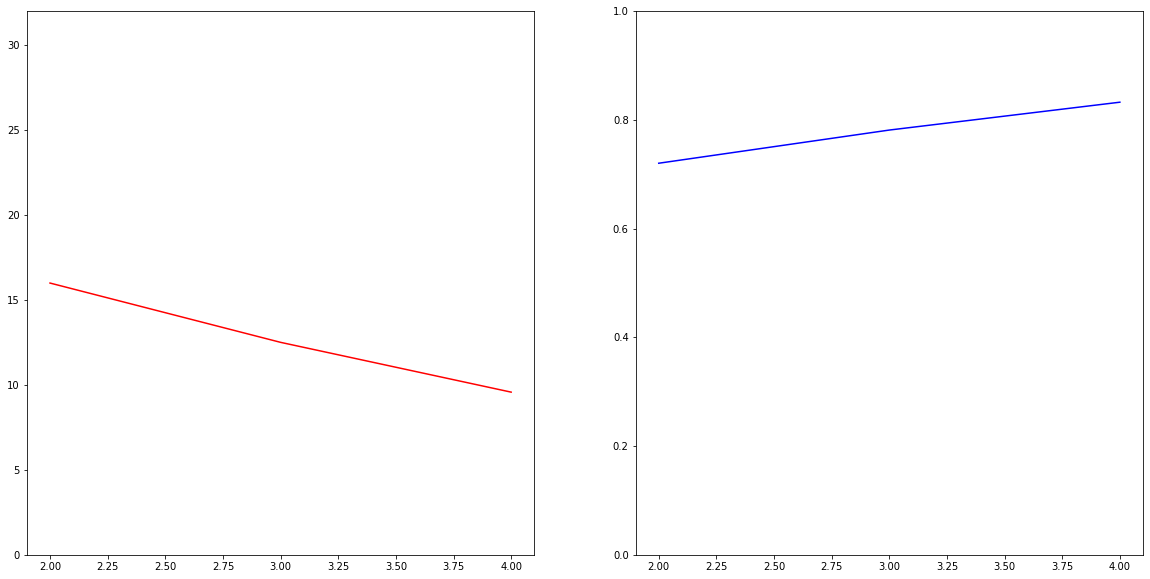

In [ ]:
fig=plt.figure(figsize=(20,10))
ax=fig.add_subplot(121)
ax.set(ylim=(0,32))
plt.plot(degrees,mse,color='r')
ax=fig.add_subplot(122)
ax.set(ylim=(0,1))
plt.plot(degrees,r2,color='b')

We can see that there might be room for improvement by further increasing the degree of the polynomial. However, the machine this was running on runs out of RAM at anything beyond a degree of 4 so we will have to make do with this level of performance.

Let's also run the metrics on the test set:

In [ ]:
X_test=pd.DataFrame(poly.transform(X_test_raw),index=X_test_raw.index)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index)
y_pred = pd.DataFrame(poly_model.predict(X_test),index=X_test.index)
print('MSE=',mean_squared_error(y_test,y_pred))
print('R2=',r2_score(y_test,y_pred))

MSE= 9.588918257348741
R2= 0.8315724763099754


This time our model produces a much more reasonable R2 value, and can even be relied on to produce a prediction:

In [ ]:
doy=dt.datetime(2022,6,27).timetuple().tm_yday
exam=np.array([2022,doy,37.9773,23.6727,20,0,0])
exam=exam.reshape(1,-1)
exam=poly.transform(exam)
exam=scaler.transform(exam)
poly_model.predict(exam)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  "X does not have valid feature names, but"


array([31.90622835])

# Classification

Now we will go on to try to predict whether it's going to rain. Since the classes are heavily unbalanced, we will make sure to stratify our split so they are both represented in the test set, and we will focus on a metric that is more suitable for this situation, specifically the F1-score. Our classifier is a decision tree, therefore standardizing the features is not necessary.

## Decision Tree

In [ ]:
X = data.drop(['MEAN_TEMP','RAIN'],axis=1)
y = data['RAIN']
X_train_raw, X_test_raw, y_train_raw, y_test_raw=train_test_split(X,y,test_size=0.1,random_state=1010034,stratify=y)

In [ ]:
%%time

k=5
tree_depths=list(range(5,26,4))
f1=dict()
f1['gini']=list()
f1['entropy']=list()
for i in tree_depths:
    for crit in ['gini','entropy']:
        f1_sum=0
        kf = KFold(n_splits=k)
        for train_index, val_index in kf.split(X_train_raw, y_train_raw):
            X_train, X_val = X_train_raw.iloc[train_index], X_train_raw.iloc[val_index]
            y_train, y_val = y_train_raw.iloc[train_index], y_train_raw.iloc[val_index]

            tree=DecisionTreeClassifier(max_depth=i, criterion=crit)
            tree.fit(X_train,y_train)
            y_pred=tree.predict(X_val)
            f1_sum+=f1_score(y_pred=y_pred,y_true=y_val)

        f1[crit].append(f1_sum/k)

CPU times: user 3min 57s, sys: 534 ms, total: 3min 57s
Wall time: 3min 56s


As can be seen from the plot, the performance peaks at a max depth of around 20. The split criterion did not make a difference in either case.

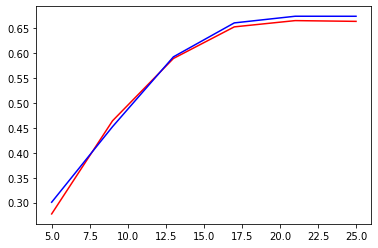

In [ ]:
plt.plot(tree_depths,f1['gini'],color='r')
plt.plot(tree_depths,f1['entropy'],color='b')

In [ ]:
y_pred=tree.predict(X_test_raw)
print(classification_report(y_pred=y_pred,y_true=y_test_raw))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86     63285
           1       0.68      0.67      0.68     27313

    accuracy                           0.81     90598
   macro avg       0.77      0.77      0.77     90598
weighted avg       0.81      0.81      0.81     90598



## Random Forest

For the final model, we will try to improve upon the performance of the decision tree by creating a random forest. We will use the hyperparameters we concluded on when tuning the tree previously and vary the number of trees.

In [ ]:
%%time

k=5

tree_nos=[1,10,50]
f1=list()
for i in tree_nos:
    f1_sum=0
    kf = KFold(n_splits=k)
    for train_index, val_index in kf.split(X_train_raw, y_train_raw):
        X_train, X_val = X_train_raw.iloc[train_index], X_train_raw.iloc[val_index]
        y_train, y_val = y_train_raw.iloc[train_index], y_train_raw.iloc[val_index]

        forest=RandomForestClassifier(max_depth=20, n_estimators=i)
        forest.fit(X_train,y_train)
        y_pred=forest.predict(X_val)
        f1_sum+=f1_score(y_pred=y_pred,y_true=y_val)

    f1.append(f1_sum/k)

CPU times: user 8min 59s, sys: 1.25 s, total: 9min
Wall time: 8min 59s


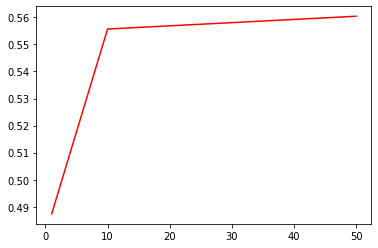

In [ ]:
plt.plot(tree_nos,f1,color='r')

In [ ]:
y_pred=forest.predict(X_test_raw)
print(classification_report(y_pred=y_pred,y_true=y_test_raw))

              precision    recall  f1-score   support

           0       0.80      0.92      0.86     63285
           1       0.72      0.46      0.56     27313

    accuracy                           0.78     90598
   macro avg       0.76      0.69      0.71     90598
weighted avg       0.77      0.78      0.77     90598



Interestingly, the performance for the random forest is worse than that of the single decision tree of the same max depth. This might imply that the decision tree was overfit despite the use of cross validation, or it might be because of differences in the internal implementation of the two classifiers by scikit-learn.